### General Assembly Code Challenge

Mark R. Yoder, Ph.D.

### Section 1

In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
#%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# standard imports (we almost always use)
import numpy
import math
import pylab as plt
#
import os
import sys
#
# some helper functions:
# Gauss math:
def gauss_multiply(g1, g2):
    # g1, g1 are tuples/lists of the gauss mu,var
    mu1, var1 = g1
    mu2, var2 = g2
    mean = (var1*mu2 + var2*mu1) / (var1 + var2)
    variance = (var1 * var2) / (var1 + var2)
    #
    return [mean, variance]
def gauss_add(g1,g2):
    return [g1[0]+g2[0], g1[1]+g2[1]]
    #return [sum(cl) for cl in zip(g1, g2)]
#
colors_ = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
#

In [26]:
# eventually we need to improve our PANDAS-foo, but let's see how genfromtxt()
#
fname_data = 'ga_data/breast-cancer.csv'
fname_cols = 'ga_data/field_names.txt'
#
# fetch field names into a list and/or string so we can pass them to genfromtxt()
with open(fname_cols) as f_cl:
    cols = [rw.strip() for rw in f_cl]
#
#mydata = numpy.genfromtxt(fname_data, delimiter=',', names=cols)
# ... and as is not unusual, numpy does a poor job of guessing data types, so we'll help. for now, assume
# the ID can be an integer (might need to make it a string):
# NOTE: it might be useful to swap out booleans for the diagnosis, {'M':1, 'B':0}
my_dtype = [(cols[0], '<i8'), (cols[1], 'S1')] + [(col, '<f8') for col in cols[2:]]
mydata = numpy.genfromtxt(fname_data, delimiter=',', dtype=my_dtype)
#
# what have we got so far?
print('col names: {}'.format(cols))
#
#for j in range(5):
#    print(mydata[j])
#



col names: ['ID', 'diagnosis', 'radius_mean', 'radius_sd_error', 'radius_worst', 'texture_mean', 'texture_sd_error', 'texture_worst', 'perimeter_mean', 'perimeter_sd_error', 'perimeter_worst', 'area_mean', 'area_sd_error', 'area_worst', 'smoothness_mean', 'smoothness_sd_error', 'smoothness_worst', 'compactness_mean', 'compactness_sd_error', 'compactness_worst', 'concavity_mean', 'concavity_sd_error', 'concavity_worst', 'concave_points_mean', 'concave_points_sd_error', 'concave_points_worst', 'symmetry_mean', 'symmetry_sd_error', 'symmetry_worst', 'fractal_dimension_mean', 'fractal_dimension_sd_error', 'fractal_dimension_worst']


### Compute the mean and median compactness and smoothness.
- Even this simple task requires a bit of iterpretation and involves a bit of subjectivity
- Do we use a weighted or unweighted mean?
- Do we consider the measurement variance, _sd_error, a refelction of our confidence in the measurement?

This latter assumption is consistent with a Bayes framework, so we'll discuss it. In such a a framework, rather than thinking in terms of, 'computing the mean value of {x},' we want to, 'find the most likely true value of {x}, given the observed data.' This means that, fundamentally, we are multiplyig Gauss distributions, $P_{12} = P_1 \cdot P_2$, as opposed to directly taking the algebric mean of the data, through additino and division.

It is easy to show with a bit of calculus that, assuming Gauss distributions, this is identically equal to a weighted mean, in which the weights $w_j = 1/\sigma_j$ (see gauss_multiply() function above). A similar principle applies to the joint variance. Expanding these forumulas for $N>2$ inputs,

\begin{equation}
<x> = \sum_j \frac{x_j}{\sigma_j} \cdot \left( \sum_j \frac{1}{\sigma_j^2} \right)^{-1}
\end{equation}

and

\begin{equation}
var(x) = \frac{\prod_j \sigma_j^2}{\sum_j \sigma_j^2},
\end{equation}

Note, however, that these numbers must be interpreted carefully. The mean value -- whether we think in terms of Bayes or compute a simple (un)weighted mean, is fairly straight forward. The variances, or uncertainties, can be a bit trickier; in this case, the variance indicates our confidence in our estimate of the mean value, but it does not speak to the expected scatter about the mean .

As we may or may not discuss, the data can be handled other ways -- for simplicity or demonstrative purposes, or to simpyl show (either explicitly or approximately) that the Gauss-Bayes frameworks are consistent with perhaps more intuitive, familiar approaches.

In order to compute the expected scatter about the mean value, we will compute the variance (or standard deviatino) of the observed data about the expected value, which assuming normal Gauss distributions, is equal to the normal variance. We we remind ourselves that errors add in quadrature:

\begin{equation}
e^2 = e_1^2 + e_2^2
\end{equation}

and so the mean variance of our observables about their mean value can be written as,

\begin{equation}
\left < var \right > = \sum_j { \left[ \left( x_j - \left<x \right> \right)^2 \right] } +  \left < \sigma^2_{measurements} \right > ,
\end{equation}

where in this case, we nominally compute $\left< \sigma^2_{measurements} \right>$ from the Bayes framework as described above, but we can also model the process in a piecewise manner, in which we consider the total variance for each measurement to be the sum of its deviation from the mean plus its inherent measurement error, 

\begin{equation}
\left < var \right > = \sum_j { \left[ \left( x_j - \left<x \right> \right)^2  +  \left < \sigma^2_{measurement~j} \right > \right] },
\end{equation}

We can, of course, trivially show that the total mean variance of the observables $x_j$ is,

\begin{equation}
\left < var \right > = var(x_j) + mean(\sigma^2_j).
\end{equation}

All of this can seem quite circular -- and it should, since minor deviations in our modeling or organization of our measurements and their error should not lead to significant differences in their computed values or algebraic forms.



In [27]:
# compute the mean and median compacthness and smoothness.
# to be demonstrative, we might make some extra copies of variables/arrays in some cases.
# note: in a pandas dataframe we can use df.groupby(), but let's be more explicit here.
#
# we could make copies of the data:
#data_M = numpy.array([rw for rw in mydata if rw['diagnosis']=='M'], dtype=my_dtype)
#data_B = numpy.array([rw for rw in mydata if rw['diagnosis']=='B'], dtype=my_dtype)
#
# or, we might just sort it and find the split:
mydata.sort(order='diagnosis')   # we know this will sort B,M
j_BM = 0
for j,diag in enumerate(mydata['diagnosis']):
    if diag.decode()=='M':
        j_BM = j
        break
#
# here's a framework for sorting/selecting via list comprehensions. for large data sets, this will be expensive
# since we have to spin through the data set each time, and in the end might need to make a copy or two anyway.
# now, we have our table effectively split into two groups.
'''
# unweighted means:
compactness_mean_uw_M = numpy.mean([x for diag, x in numpy.array([mydata['diagnosis'], mydata['compactness_mean']]).T if diag=='M'])
smoothness_mean_uw_M  = numpy.mean([x for diag, x in numpy.array([mydata['diagnosis'], mydata['smoothness_mean']]).T if diag=='M'])
#
compactness_mean_w_M = numpy.average([x for diag, x, wt in numpy.array([mydata['diagnosis'], mydata['compactness_mean'],
                                                                        1./mydata['compactness_sd_error']]).T if diag=='M'], )
smoothness_mean_w_M  = numpy.average([x for diag, x, wt in numpy.array([mydata['diagnosis'], mydata['smoothness_mean']]).T if diag=='M'])
#
compactness_median_M = numpy.median([x for diag, x in numpy.array([mydata['diagnosis'], mydata['compactness_mean']]).T if diag=='M'])
smoothness_median_M  = numpy.median([x for diag, x in numpy.array([mydata['diagnosis'], mydata['smoothness_mean']]).T if diag=='M'])

'''
#
# stash the values in a dict{} object for convenience:
#
my_meas = {}
#
# Compactness:
#
# simple unweighted mean value:
#my_meas['comp_mean_uw_M'] = numpy.mean(mydata['compactness_mean'][j_BM:])
#my_meas['comp_mean_uw_MB] = numpy.mean(mydata['compactness_mean'][:j_BM])
#
# ... and median:
my_meas['comp_median_M'] = numpy.median(mydata['compactness_mean'][j_BM:])
my_meas['comp_median_B'] = numpy.median(mydata['compactness_mean'][:j_BM])
#
# weighted mean (for Bayes framework)
# the weighted mean effectively gives the maximum likelihood for the joint probability of "the data, given the mean", P(B|A)
# in a Bayes framework (see gauss_multiply() function above)
my_meas['comp_mean_w_M'] = numpy.average(mydata['compactness_mean'][j_BM:], weights=1./mydata['compactness_sd_error'][j_BM:])
my_meas['comp_mean_w_B'] = numpy.average(mydata['compactness_mean'][:j_BM], weights=1./mydata['compactness_sd_error'][:j_BM])
#
# and following the same Bayes framework, we can compute the joint variance about those values (again, see gauss_multiply() above):
# note: this gives us the variance of the mean value (aka, our confidence in our mean value), not the scatter of the observables.
my_meas['comp_var_w_M'] = numpy.prod(mydata['compactness_sd_error'][j_BM:])/numpy.sum(mydata['compactness_sd_error'][j_BM:])
my_meas['comp_var_w_B'] = numpy.prod(mydata['compactness_sd_error'][:j_BM])/numpy.sum(mydata['compactness_sd_error'][:j_BM:])
#
# Variance:
# note also: we're being a bit sloppy with the 1/N vs 1/(N-1) denominators here, simply because numpy.mean() is fast and easy to
# write. of course, it for large N, the difference is very very small.
# again, specifically what variance are we talking about? The plain, vanilla variance is about the data's (presumably
# unweighted) mean value:
#my_meas['comp_var_data_M'] = numpy.var(mydata['compactness_mean'][j_BM:])
#my_meas['comp_var_data_B'] = numpy.var(mydata['compactness_mean'][:j_BM])
#
# but arguably, we want to explicitly compute the mean variance about the weighted, Bayes mean:
my_meas['comp_var_mean_M'] = numpy.mean((mydata['compactness_mean'][j_BM:] - my_meas['comp_mean_w_M'])**2.)
my_meas['comp_var_mean_B'] = numpy.mean((mydata['compactness_mean'][:j_BM] - my_meas['comp_mean_w_B'])**2.)
#
# Smoothness:
#
my_meas['smoothness_mean_uw_M'] = numpy.mean(mydata['smoothness_mean'][j_BM:])
my_meas['smoothness_mean_uw_B'] = numpy.mean(mydata['smoothness_mean'][:j_BM])
#
my_meas['smoothness_median_M'] = numpy.median(mydata['smoothness_mean'][j_BM:])
my_meas['smoothness_median_B'] = numpy.median(mydata['smoothness_mean'][:j_BM])
#
my_meas['smoothness_mean_w_M'] = numpy.average(mydata['smoothness_mean'][j_BM:], weights=1./mydata['smoothness_sd_error'][j_BM:])
my_meas['smoothness_mean_w_B'] = numpy.average(mydata['smoothness_mean'][:j_BM], weights=1./mydata['smoothness_sd_error'][:j_BM])
#
# and following the same Bayes framework, we can compute the joint variance about those values (again, see gauss_multiply() above):
my_meas['smoothness_var_w_M'] = numpy.prod(mydata['smoothness_sd_error'][j_BM:])/numpy.sum(mydata['smoothness_sd_error'][j_BM:])
my_meas['smoothness_var_w_B'] = numpy.prod(mydata['smoothness_sd_error'][:j_BM])/numpy.sum(mydata['smoothness_sd_error'][:j_BM:])

#
# so now, write a little report. note, it might make sense to stash these values into a dict{} object. we'll likely come
# back and do this...
#

/home/myoder/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in true_divide
/home/myoder/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:950: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt).sum(axis)/scl


### What did we get?
- Print the computed statistics
- We expect to see consistency (but not exact replication) between:
  - Mean and median values for each group
  - Different methods of computing the mean (weighted vs unweighted, etc.)
  - Different methdos of computing the variance



In [28]:
for key,val in sorted(my_meas.items(), key=lambda rw:rw[0]):
    print('{}:: {}'.format(key,val))
    

comp_mean_w_B:: nan
comp_mean_w_M:: 0.026153297159129223
comp_median_B:: 0.01631
comp_median_M:: 0.028589999999999997
comp_var_mean_B:: nan
comp_var_mean_M:: 0.0003740447603522369
comp_var_w_B:: 0.0
comp_var_w_M:: 1.3723714654838955e-304
smoothness_mean_uw_B:: 2.0003212885154062
smoothness_mean_uw_M:: 4.323929245283018
smoothness_mean_w_B:: 1.7748802316896377
smoothness_mean_w_M:: 3.2147266438958653
smoothness_median_B:: 1.851
smoothness_median_M:: 3.6795
smoothness_var_w_B:: inf
smoothness_var_w_M:: inf


### Comments: What happened?
- What is a "$nan$"? "Not a nuumber," but what does that mean?
- Why do we get "$nan$" values?

Handling $nan$ values is an unholy part of data science. Libraries like $sklearn$ and $pandas$ tend to have built in methods to handle $nan$ values. If there is any one great reason, aside from compiled performance, to use one of these libraries, as opposed to building your own code from scratch $nans$ are it.

But that't not the whole story in this case. Why do we get $nan$ values for our weighted Bayes variance calculation? Hint: the number is simply too large. What can we do to resolve this?

In the end, the variance should be a reasonalbe, computatioanlly finite number. However, when we compute the complete prod(X) and sum(X) components in th enumerator/denominator, these numbers can get really, really big, and so we get an overflow. In order to compute the joint variance for more than a few numbers at a time, we need to wrie an iterator of some sort; we leave this as an exercise for the reader. Additionally, when we compute a weighted average using $1/\sigma^2$ as weights, we will get a $1/0$ error, which will probably be trapped as a $nan$, and so we need to handle that scenario as well.

This, and other aspects of the outcome, suggest a short discussion (or at least private think on your own time) of, "the perfect vs the good." Sometimes, the quick, easy, and robust approach has advantages over a fully proper treatment. We illustrate by substituting some simple approximations for the problematic statistics above.

Also, having taken a break and recognizing that our code could be a bit more clear, we'll introduce some pointer-shorthand variables.

In [29]:
# shorthand:
mydata_B = mydata[:j_BM]
mydata_M = mydata[j_BM:]
#
# unwieghted "normal" variances
# these values might be a bit off their fully rigorously handled counterparts, but 1) they should
# be very close, and 2) these calculations are usually very robust.
#
# TODO: properly handle the rigorous statistical/probability calculations. for now, let's just use
#       the simple approximations for proof of concept and to lay down our framework.
#
my_meas['smoothness_var_simple_B'] = numpy.var(mydata_B['smoothness_mean'])
my_meas['smoothness_var_simple_M'] = numpy.var(mydata_M['smoothness_mean'])

my_meas['comp_var_simple_B'] = numpy.var(mydata_B['compactness_mean'])
my_meas['comp_var_simple_M'] = numpy.var(mydata_M['compactness_mean'])

my_meas['smoothness_mean_simple_B'] = numpy.mean(mydata_B['smoothness_mean'])
my_meas['smoothness_mean_simple_M'] = numpy.mean(mydata_M['smoothness_mean'])

my_meas['comp_mean_simple_B'] = numpy.mean(mydata_B['compactness_mean'])
my_meas['comp_mean_simple_M'] = numpy.mean(mydata_M['compactness_mean'])

In [30]:
for key,val in sorted(my_meas.items(), key=lambda rw:rw[0]):
    print('{}:: {}'.format(key,val))

comp_mean_simple_B:: 0.02143824649859944
comp_mean_simple_M:: 0.03228116509433963
comp_mean_w_B:: nan
comp_mean_w_M:: 0.026153297159129223
comp_median_B:: 0.01631
comp_median_M:: 0.028589999999999997
comp_var_mean_B:: nan
comp_var_mean_M:: 0.0003740447603522369
comp_var_simple_B:: 0.0002666229828075858
comp_var_simple_M:: 0.0003364939949208571
comp_var_w_B:: 0.0
comp_var_w_M:: 1.3723714654838955e-304
smoothness_mean_simple_B:: 2.0003212885154062
smoothness_mean_simple_M:: 4.323929245283018
smoothness_mean_uw_B:: 2.0003212885154062
smoothness_mean_uw_M:: 4.323929245283018
smoothness_mean_w_B:: 1.7748802316896377
smoothness_mean_w_M:: 3.2147266438958653
smoothness_median_B:: 1.851
smoothness_median_M:: 3.6795
smoothness_var_simple_B:: 0.5930361074459587
smoothness_var_simple_M:: 6.566306839333393
smoothness_var_w_B:: inf
smoothness_var_w_M:: inf


### Cumulative distributions: Moving towards predictive analytics

- Compute cumulative distributions of the mean and maybe variance statistics to indicate a relationship between those metrics and probability of malignancy.
- The simplest way to compute a probability distribution is to simply plot the (normalized) count of "events" vs the metric in question. The easiest way to do the same is to use the pylab.hist(X, cumulative=True) function
- We're going to use this direct approach. When might this cause HUGE problems?
- We fit the data to a cumulative exponential distribution, 

\begin{equation}
P(x) = e^{\frac{x_0 - x}{\chi}}
\end{equation}

- Then, we plot the data (dots) compared to the model (lines)
- This model shows the probability that a measurement is less than $x$ (aka, 90% of all benign tumors have a compactness measureement $c<0.04$.
- We also show complimentary probability in the dashed curves -- aka, the probability that a benign tumor has a compactness measurement $c>0.05$ is approximately 10%.


- We might also look at the _sd_error columns. Nominally these strictly indicate measurement error, but in many cases, they may also contain information. Of coruse, that information may be correlated with other measurements.
- For example, we might expect higher measurement errors associated with less compact shapes, simply because those shapes are more difficult to measure precisely and/or accurately.

<IPython.core.display.Javascript object>


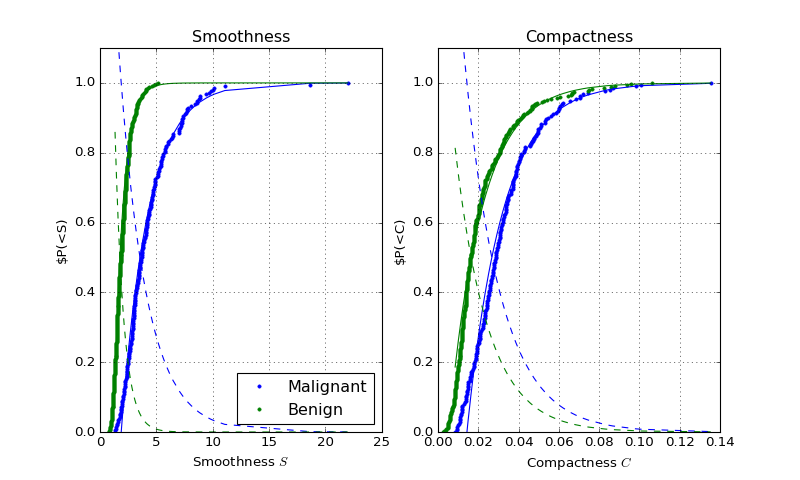

**  [ 0.78203023 -0.41599299]
**  [ 1.545313  -1.2717862]
**  [  0.79920946 -56.00757688]
**  [  0.31012311 -61.2656326 ]


In [31]:
# note: this code is not optimized, but it is a bit more demonstrative.
#
plt.figure(figsize=(10,6))
plt.clf()
ax1=plt.subplot('121')
ax2=plt.subplot('122')
#
Xs_M = numpy.array(sorted(mydata_M['smoothness_mean']))
Ys_M = numpy.linspace(0., 1., len(Xs_M))
Xs_B = numpy.array(sorted(mydata_B['smoothness_mean']))
Ys_B = numpy.linspace(0., 1., len(Xs_B))
#
Xc_M = numpy.array(sorted(mydata_M['compactness_mean']))
Xc_B = numpy.array(sorted(mydata_B['compactness_mean']))
Yc_M = numpy.linspace(0., 1., len(Xc_M))
Yc_B = numpy.linspace(0., 1., len(Xc_B))
#
# exponential() fits?
# exclude first/last values to avoid zero problems.
lsqs_sm = numpy.linalg.lstsq([[1., x] for x in Xs_M[1:-1]], [numpy.log(1.-p) for p in Ys_M[1:-1]])
lsqs_sb = numpy.linalg.lstsq([[1., x] for x in Xs_B[1:-1]], [numpy.log(1.-p) for p in Ys_B[1:-1]])
lsqs_cm = numpy.linalg.lstsq([[1., x] for x in Xc_M[1:-1]], [numpy.log(1.-p) for p in Yc_M[1:-1]])
lsqs_cb = numpy.linalg.lstsq([[1., x] for x in Xc_B[1:-1]], [numpy.log(1.-p) for p in Yc_B[1:-1]])

#lsqs_sm = numpy.linalg.lstsq([[x] for x in Xs_M[1:-1]], [numpy.log(1.-p) for p in Ys_M[1:-1]])
#lsqs_sb = numpy.linalg.lstsq([[x] for x in Xs_B[1:-1]], [numpy.log(1.-p) for p in Ys_B[1:-1]])
#lsqs_cm = numpy.linalg.lstsq([[x] for x in Xc_M[1:-1]], [numpy.log(1.-p) for p in Yc_M[1:-1]])
#lsqs_cb = numpy.linalg.lstsq([[x] for x in Xc_B[1:-1]], [numpy.log(1.-p) for p in Yc_B[1:-1]])

for lsq in [lsqs_sm, lsqs_sb, lsqs_cm, lsqs_cb]:
    print('** ', lsq[0])
#
def f_exp_cum(x, a, b):
    # note, a should be negative...
    return 1. - numpy.exp(a + b*x)
#
ax1.plot(Xs_M, Ys_M, ls='', marker='.', label='Malignant', color='b')
ax1.plot(Xs_B, Ys_B, ls='', marker='.', label='Benign', color='g')
#
ax1.plot(Xs_M, f_exp_cum(Xs_M, *lsqs_sm[0]), marker='', ls='-', color='b')
ax1.plot(Xs_M, f_exp_cum(Xs_M, *lsqs_sb[0]), marker='', ls='-', color='g')
ax1.plot(Xs_M, 1. - f_exp_cum(Xs_M, *lsqs_sm[0]), marker='', ls='--', color='b')
ax1.plot(Xs_M, 1. - f_exp_cum(Xs_M, *lsqs_sb[0]), marker='', ls='--', color='g')

#
ax2.plot(Xc_M, Yc_M, ls='', marker='.', label='Malignant', color='b')
ax2.plot(Xc_B, Yc_B, ls='', marker='.', label='Benign', color='g')
#
ax2.plot(Xc_M, f_exp_cum(Xc_M, *lsqs_cm[0]), marker='', ls='-', color='b')
ax2.plot(Xc_M, f_exp_cum(Xc_M, *lsqs_cb[0]), marker='', ls='-', color='g')
#
ax2.plot(Xc_M, 1.-f_exp_cum(Xc_M, *lsqs_cm[0]), marker='', ls='--', color='b')
ax2.plot(Xc_M, 1.-f_exp_cum(Xc_M, *lsqs_cb[0]), marker='', ls='--', color='g')

#
ax1.legend(loc=0, numpoints=1)
ax1.set_ylim(0., 1.1)
ax1.set_title('Smoothness')
ax1.set_ylabel('$P(<S)')
ax1.set_xlabel('Smoothness $S$')
ax1.grid()

ax2.set_ylim(0., 1.1)
ax2.set_title('Compactness')
ax2.set_ylabel('$P(<C)')
ax2.set_xlabel('Compactness $C$')
ax2.grid()


### Are they different?
- They sure do look different
- We can use a t-test to determine whether or not they are different
- a t-test is actually a general term for determining whether two populations are different (have a different mean measured value); there is no one t-test.
- the basic form is (typically) something like:

\begin{equation}
t = \frac{(\mu_1 - \mu_2)^2}{\sigma_1^2 + \sigma_2^2} ,
\end{equation}

where the denominator is some meaningful representation of the joint variance of the two measurements -- so bascially, are the mean values of the two (groups of) measurements separated by more than a standard deviation or so? Not that what constitutes "separate" is a subjective choice of $t$ -- aka, separated by how many (fractions of a) standard deviation? Also, the joint variance can be computed many other ways -- see for example the Gauss multiplication joint variance formula above.

In our case, we see for compactness, $t \approx 0.1/.0005$, so these two populations can be considered to be statistically distinct. Conversely, for smoothness, we observe $t \approx (4.2 - 2.0)^2/(0.59 + 6.6)

### Some modeling and predictive analytics
- There are lots of ways to do this
- Different bodies of literature prefer different approaches.
- I am not a physician.
- But, a reasonable approach seems to be to:
   1) Assume a linar model
   2) Create an output vector of dummy-variables from the diagnosis column where:
      - v = {B --> 0, M -- 1}
   3) Solve/optimize the matrix equation:
      $A \ccdot b = v$
   4) A is built from our observables:
           A = [[1., x_1, x_2, ..., x_n], ...]
      which means that A is basically a matrix of log-probabilities (assuming exponentail models)
   5) In reality, we often start with a linear model of some indicators, and then sort out the probability normalization and the details of the rationale later. As often as not, correct rank order is far more important than computing the correct probability.
- Nominally, we should probably start by just chucking all the numerical data into a matrix, do a fit, and see what we get.
- We would then (nominally) reduce the dimensionalaity by doing a PCA, reconstructing on the large eigenvectors, rotating back, and then taking special note of the columns with large linear coefficients.
- Note that 1) there will be a fair bit of covariance in some of these measurements, and 2) in order to properly assess which elements are really important, we most likely need to regularize the matrix somehow (aka, scale the parameters so they are on common footing). One way to do this is to substitute the measurement values with their corresponding values from a probability distribution (aka, replace some value $a$ with its corresponting $P(a)$.
- In the end, regularization can be highly subjective.
- There are a number of conventional approaches to doing this; see for example discussions of "covariance vs correlation", where we use a normalized version of covariance like (assuming some sort of non-zero, either all positive or all negative, measuremeht), $c_{xy} = cov_{xy}/<x><y> $, so that we are comparing the variation of some variable to its mean value.

In [32]:
print(mydata.dtype.names)

('ID', 'diagnosis', 'radius_mean', 'radius_sd_error', 'radius_worst', 'texture_mean', 'texture_sd_error', 'texture_worst', 'perimeter_mean', 'perimeter_sd_error', 'perimeter_worst', 'area_mean', 'area_sd_error', 'area_worst', 'smoothness_mean', 'smoothness_sd_error', 'smoothness_worst', 'compactness_mean', 'compactness_sd_error', 'compactness_worst', 'concavity_mean', 'concavity_sd_error', 'concavity_worst', 'concave_points_mean', 'concave_points_sd_error', 'concave_points_worst', 'symmetry_mean', 'symmetry_sd_error', 'symmetry_worst', 'fractal_dimension_mean', 'fractal_dimension_sd_error', 'fractal_dimension_worst')


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[b'B' b'B' b'B' b'B' b'B' b'B' b'B' b'B' b'B' b'B']
lsq:  [-0.0388698   2.00916711  0.12569993]


<IPython.core.display.Javascript object>


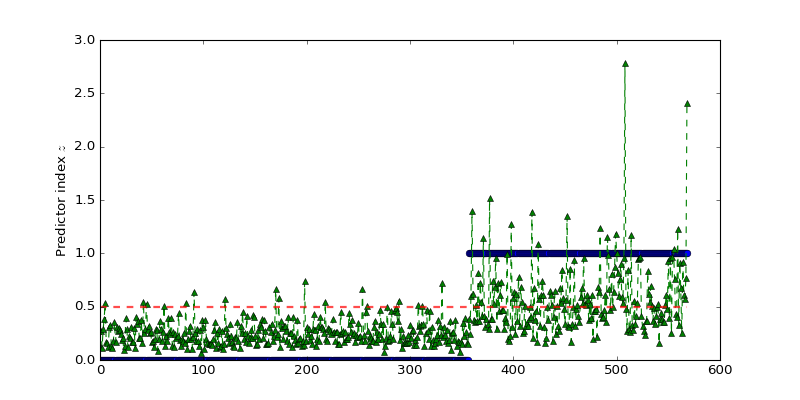

In [33]:
A = numpy.array([numpy.ones(len(mydata)), mydata['compactness_mean'], mydata['smoothness_mean']]).T
v = numpy.array([float(x.decode()=='M') for x in mydata['diagnosis']])
lsq_p = numpy.linalg.lstsq(A,v)
Z_predictor = numpy.dot(A,lsq_p[0])
print(v[0:10])
print(mydata['diagnosis'][0:10])
#
print('lsq: ', lsq_p[0])
#
plt.figure(figsize=(10,5))
ax1=plt.subplot('111')
ax1.plot(v, marker='o', ls='', label='data')
ax1.plot(Z_predictor, ls='--', marker='^', label='model')
ax1.plot([0, len(A)-1], [.5, .5], ls='--', marker='', lw=2., alpha=.7, color='r')
ax1.set_ylabel('Predictor index $z$')
#

### Assessing our predictive model
- We can see a split visually, noting that our data are still sorted by diagnoses
- NOTE: We have performed the fit over all of our data, so we run the risk of over-fitting. If we decide that this is a problem, we can perform the fitting over random samples of the data.

In general, what do we do next? We want to use these data for diagnostic purposes, so we need to choose a threshold below which we predict a tumor is benign and above which we precict that it is malignent.
- We draw a line at $z=0.5$, for reference.
- We want to the model to accurately predict positives and at the same time minimize false positives.
- We can use an ROC analysis for this. There are good, fast ways to compute ROC (see my yodiipy GitHub reposiory), but to be quick about it, and since our data set is fairly small, we're going to do it a simple, sloppy way.


For ROC analysis, we have a contingency table:

A: predicted True, observed True

B: predicted True, observed False

C: Predicted False, observed True

D: Predicted False, Observed False


The hit rate $H = A/(A+C)$
The False alarm rate $F = B/(B+D)$

For simplicity, we will walk through the full range of hazard metric thresholds, compute A,B,C,D for each step, and then compute H,F. 

The "skill" score indicates the area between random, $H=F$ and the computed $H(F)$ curve. As we can (will) see, our model scores $skill = 0.38$, of a maximum $skill = 0.5$, which indicates that it has signficant predictive ability.


In [34]:
Z_predictor_M = Z_predictor[j_BM:]
Z_predictor_B = Z_predictor[:j_BM]
# 
FH = []
for z0 in sorted(Z_predictor):
    A = len([z for z in Z_predictor_M if z>=z0])
    B = len([z for z in Z_predictor_B if z>=z0])
    #
    #C = len([z for z in Z_predictor_M if z<z0])
    #D = len([z for z in Z_predictor_B if z<z0])
    C = len(Z_predictor_M)-A
    D = len(Z_predictor_B)-B
    #
    # note: this is common notation for ROC, but in the end, it is the "hit rate",
    # (n predicted from actual list)/len(actual list),
    # and the false-alarm rate, (n predicted from benign list)/len(benign list)
    H = A/(A+C)
    F = B/(B+D)
    #
    FH += [[F,H]]
#
FH.sort(key=lambda rw:rw[0])
#
# ... and compute skill. Note that for a sparse ROC, this metric will over-estimate the skill by performing
# a rectangular integration along the F=H line. we can either solve this geometrically or interpolate
# the sequence (see scipy.interpolate)
skill = sum([(y-x)*(x-FH[j][0]) for j, (x,y) in enumerate(FH[1:])])


<IPython.core.display.Javascript object>


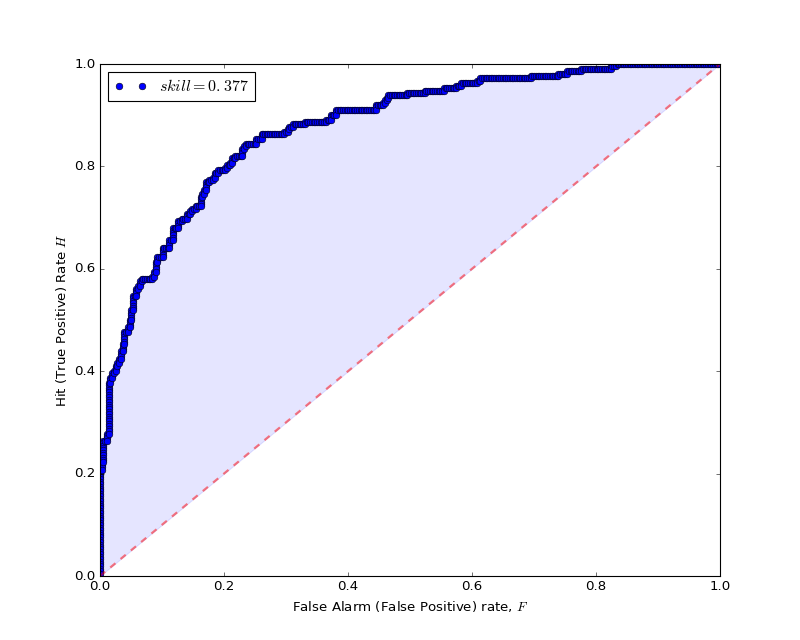

In [35]:
plt.figure(figsize=(10,8))
plt.clf()
ax1=plt.subplot('111')
#
ax1.plot(*zip(*FH), ls='', marker='o', color='b', label='$skill = {:.3f}$'.format(skill))
ax1.plot(range(2), range(2), ls='--', lw=2., alpha=.5, color='r')
ax1.fill_between([x for x,y in FH], [x for x,y in FH], [y for x,y in FH], color='b', alpha=.1)
ax1.legend(loc=0)
ax1.set_xlabel('False Alarm (False Positive) rate, $F$')
ax1.set_ylabel('Hit (True Positive) Rate $H$')

### Section 2
